In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 13.1

In [2]:
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

#### Code 13.2

In [3]:
Mu = [a, b]  

#### Code 13.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [5]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6

In [6]:
N_cafes = 20

#### Code 13.7

In [7]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

#### Code 13.8

In [8]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 13.9

In [9]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * chi2.ppf(level, 2)) #get size corresponding to level
        ell = Ellipse(mu[:2], v[0], v[1], 180 + angle, facecolor='None',
                      edgecolor='k',
                      alpha=(1-level)*.5,
                      lw=1.5)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    return ax

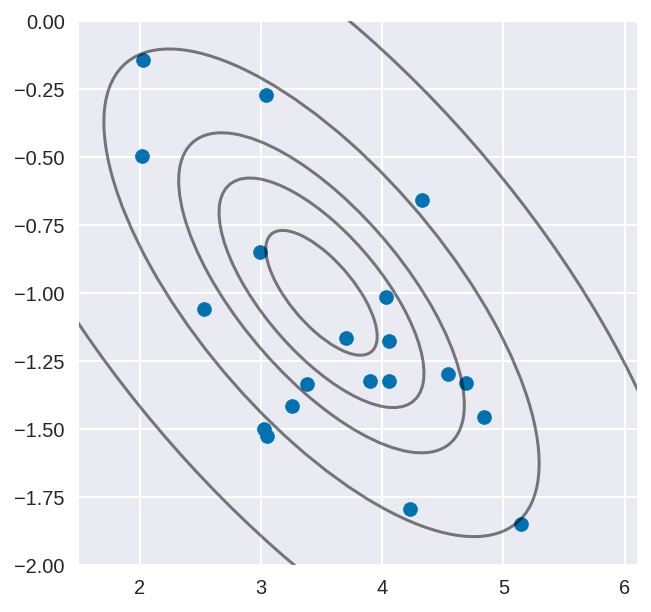

In [10]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a_cafe, b_cafe)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2, 0);

#### Code 13.10

In [11]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

#### Code 13.11

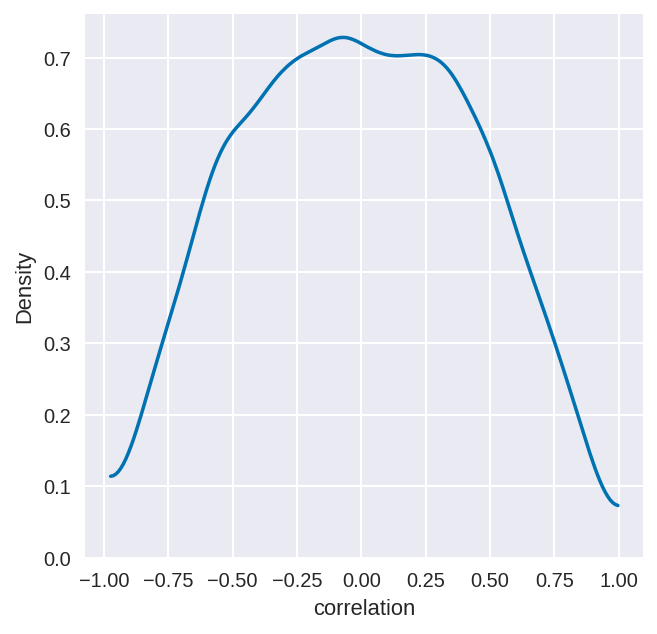

In [12]:
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(R, ax=ax);
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

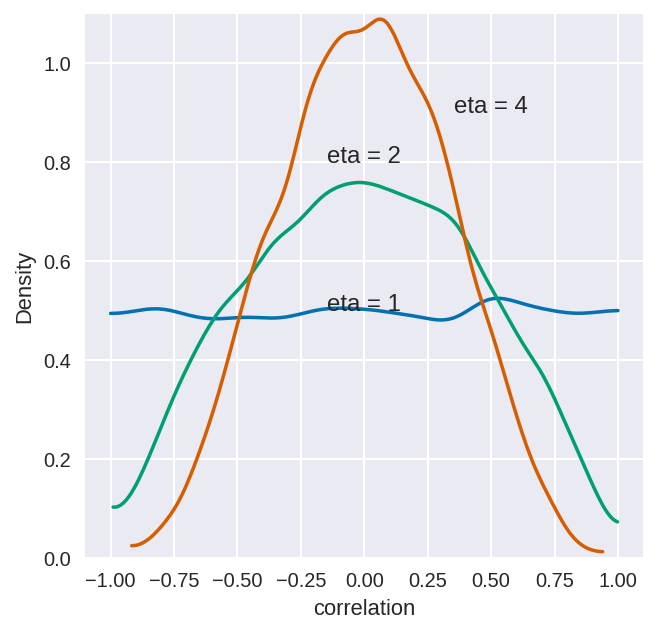

In [13]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(R, ax=ax);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.12

In [14]:
cafe_idx = d['cafe'].values
with pm.Model() as m_13_1:
    sd_dist = pm.HalfCauchy.dist(beta=2) # This is the same as sigma_cafe ~ dcauchy(0,2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sigma', beta=2)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    trace_13_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 96%|█████████▌| 6696/7000 [00:45<00:01, 175.54it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 6939/7000 [00:46<00:00, 182.41it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:46<00:00, 149.36it/s]


For complicate model it is always good to do more checks:

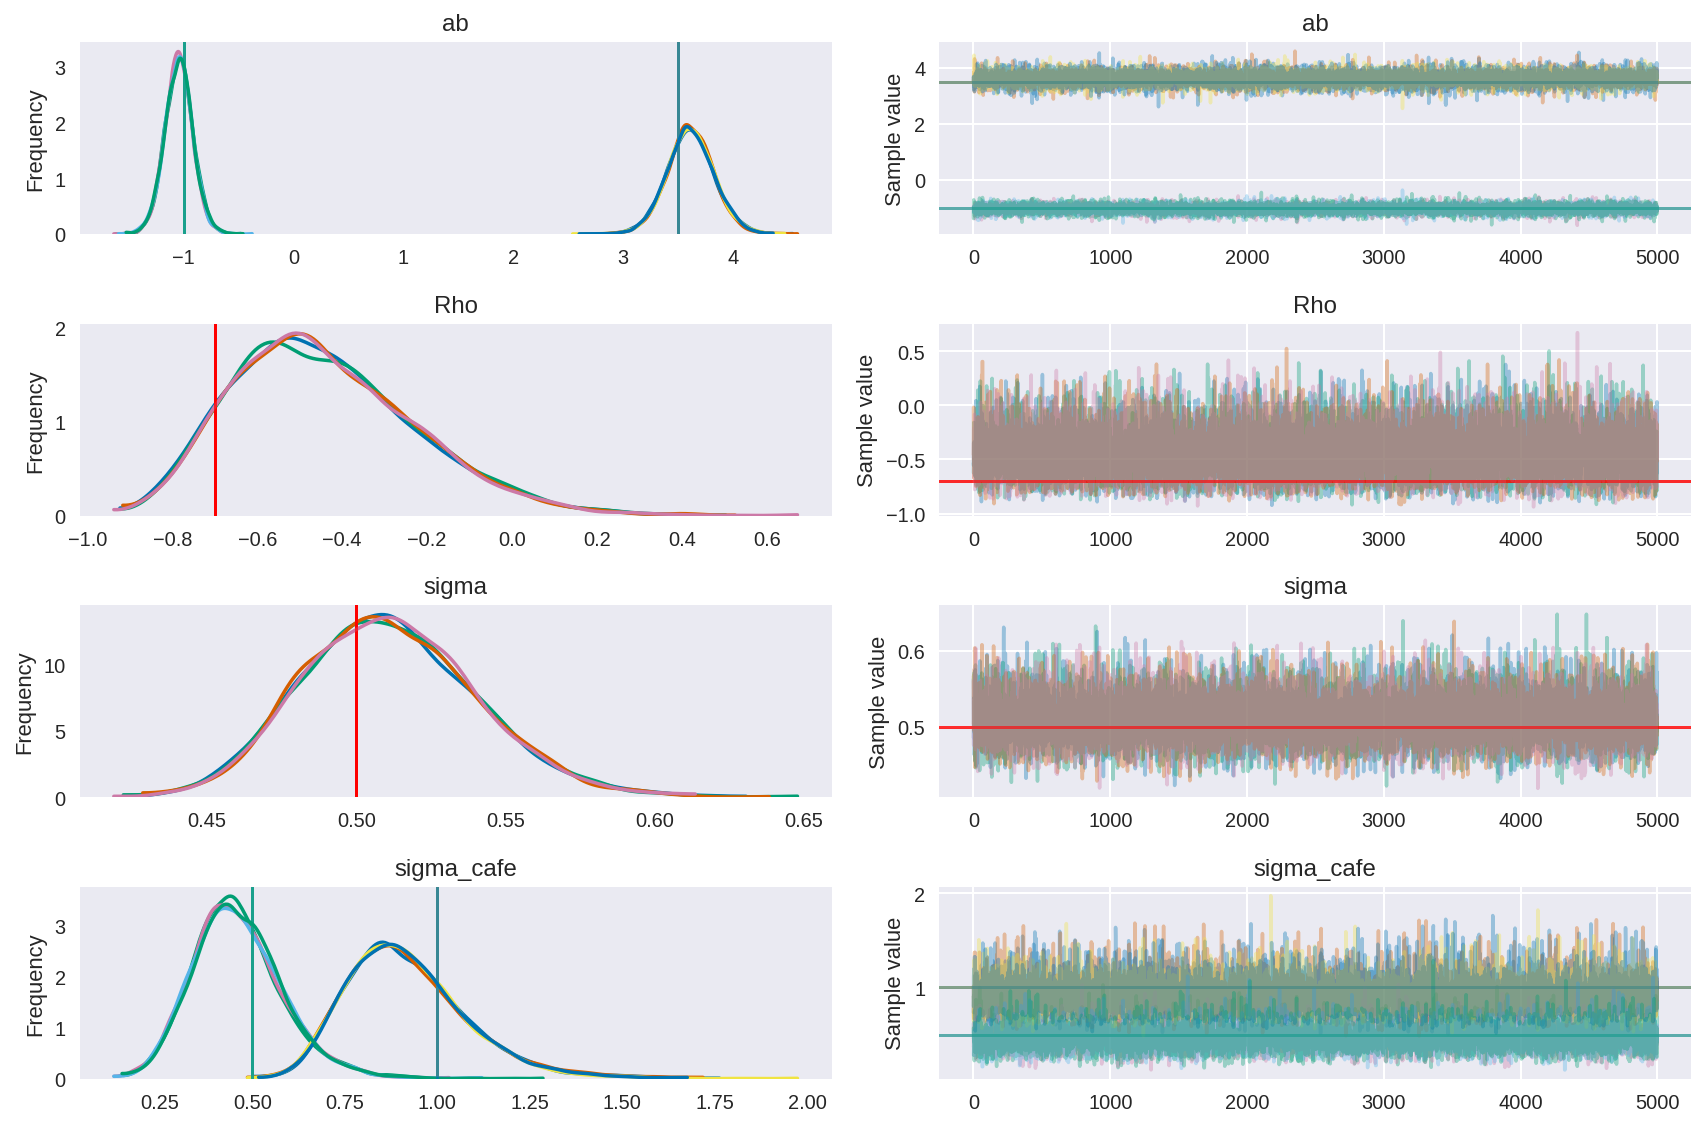

In [15]:
pm.traceplot(trace_13_1, varnames=['ab', 'Rho', 'sigma', 'sigma_cafe'],
             lines={"ab": Mu,
                    "Rho": rho,
                    "sigma": sigma,
                    "sigma_cafe": sigmas});

#### Code 13.13

In [16]:
post = pm.trace_to_dataframe(trace_13_1)

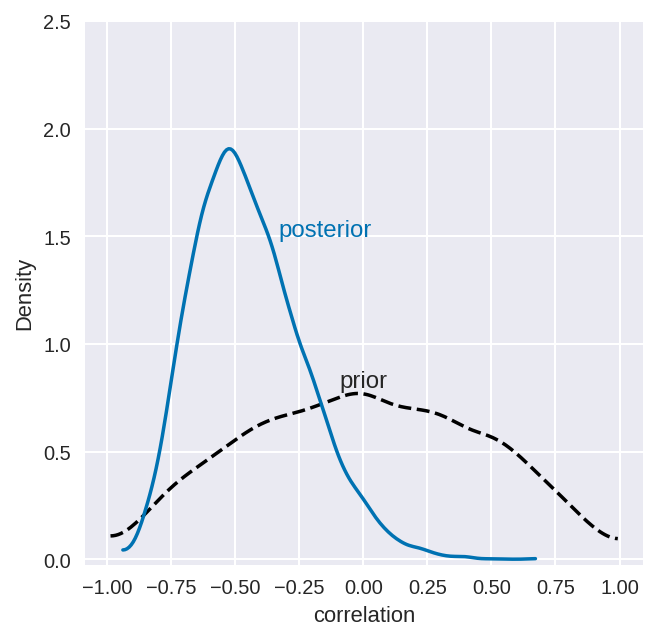

In [17]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
pm.kdeplot(R, ax=ax, color='k', linestyle='--')
ax.text(0, .8, 'prior', horizontalalignment='center')
pm.kdeplot(trace_13_1['Rho'], ax=ax, color='C0')
ax.text(-.15, 1.5, 'posterior', color='C0', horizontalalignment='center')
ax.set_ylim(-.025, 2.5)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.14

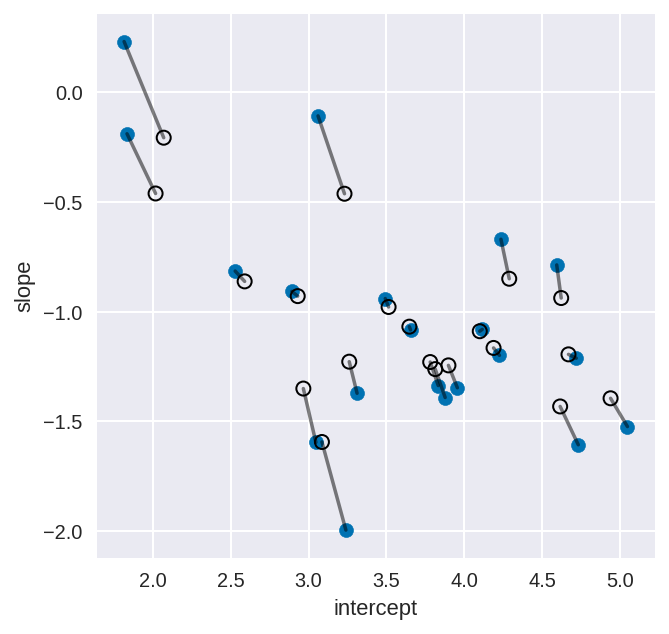

In [18]:
# compute unpooled estimates directly from data
a1b1 = (d.groupby(['afternoon', 'cafe'])
        .agg('mean')
        .unstack(level=0)
        .values)
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = trace_13_1['ab_cafe'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope');

#### Code 13.15

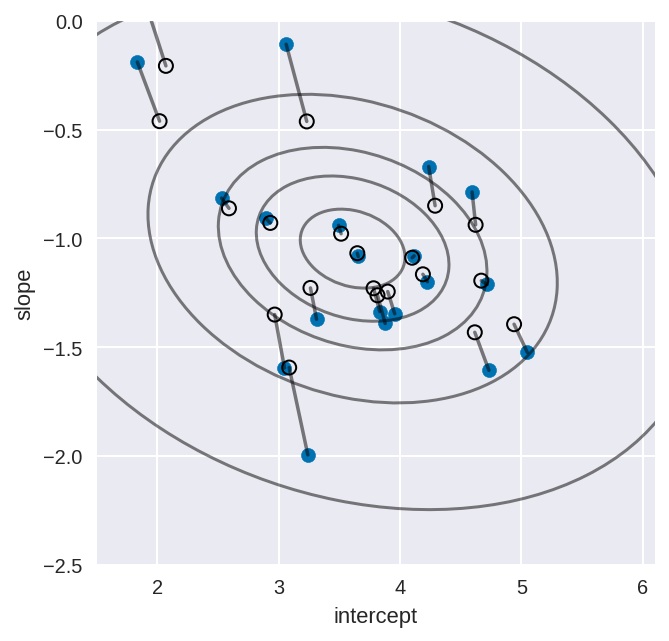

In [19]:
# compute posterior mean bivariate Gaussian
Mu_est = trace_13_1['ab'].mean(axis=0)
Chol_cov = trace_13_1['chol_cov'].mean(axis=0)
L_chol = np.zeros((2, 2))
L_chol[np.triu_indices(2, 0)] = Chol_cov
Sigma_est = np.dot(L_chol, L_chol.T)
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu_est, np.asarray(Sigma_est), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope')
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2.5, 0);

#### Code 13.16

In [20]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

#### Code 13.17

In [21]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

#### Code 13.18

In [22]:
Dept_id = d_ad['dept_id'].values
Ndept = len(d_ad['dept_id'].unique())
with pm.Model() as m_13_2:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_2 = pm.sample(4500, tune=500, njobs=3)

pm.summary(trace_13_2, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:06<00:00, 753.16it/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.58,0.65,0.01,-1.60,0.39,11383.0,1.0
bm,-0.10,0.08,0.00,-0.22,0.03,7421.0,1.0
a_dept__0,0.67,0.10,0.00,0.51,0.83,9058.0,1.0
a_dept__1,0.63,0.11,0.00,0.46,0.82,9816.0,1.0
a_dept__2,-0.58,0.08,0.00,-0.70,-0.46,13339.0,1.0
a_dept__3,-0.62,0.09,0.00,-0.75,-0.48,11775.0,1.0
a_dept__4,-1.06,0.10,0.00,-1.21,-0.90,13500.0,1.0
a_dept__5,-2.61,0.16,0.00,-2.86,-2.37,13500.0,1.0
sigma_dept,1.48,0.58,0.01,0.71,2.17,9743.0,1.0


#### Code 13.19

In [23]:
with pm.Model() as m_13_3:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_cafe', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    a_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_3 = pm.sample(5000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 95%|█████████▍| 5671/6000 [00:51<00:02, 111.76it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 147 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 5936/6000 [00:53<00:00, 114.75it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 11 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 5989/6000 [00:54<00:00, 124.13it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 12 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [00:54<00:00, 110.58it/s]
/ho

#### Code 13.20

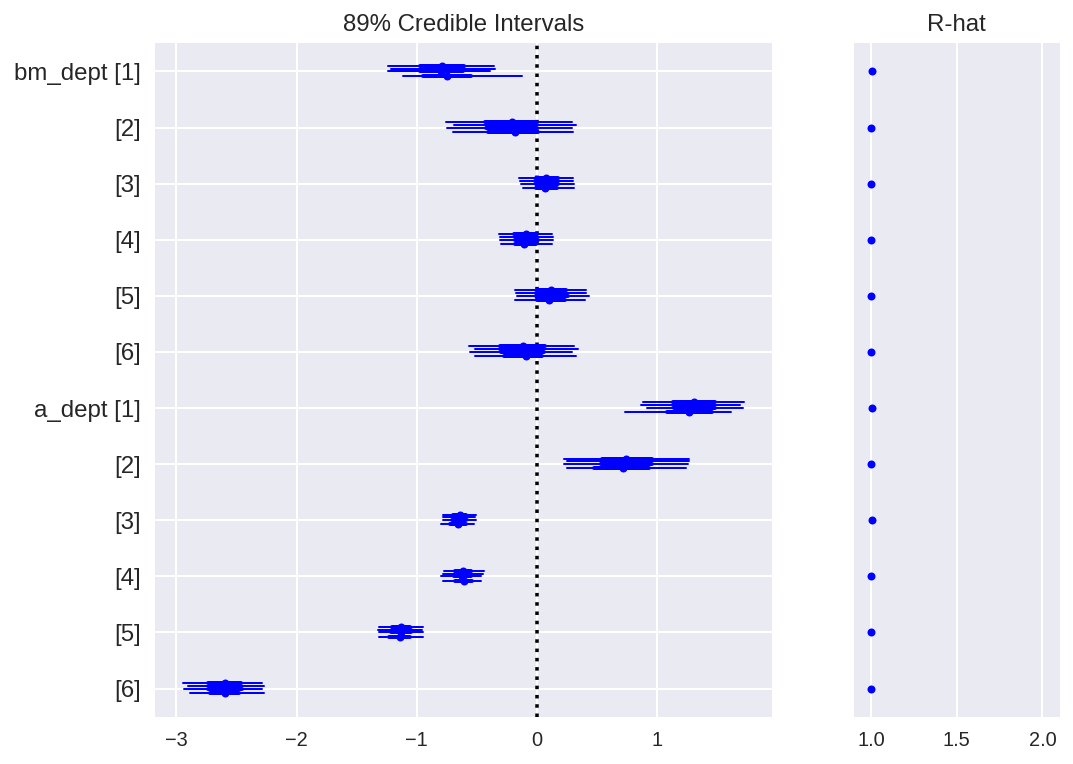

In [24]:
pm.forestplot(trace_13_3, varnames=['bm_dept', 'a_dept'], alpha=.11);

#### Code 13.21

In [25]:
with pm.Model() as m_13_4:
    a = pm.Normal('a', 0, 10)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_4 = pm.sample(4500, tune=500, njobs=3)
    
comp_df = pm.compare([trace_13_2, trace_13_3, trace_13_4], 
                     [m_13_2, m_13_3, m_13_4])

comp_df.loc[:,'model'] = pd.Series(['m13.2', 'm13.3', 'm13.4'])
comp_df = comp_df.set_index('model')
comp_df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:05<00:00, 912.76it/s] 


,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m13.3,91.45,6.96,0,0.84,4.87,0,1
m13.4,104.96,6.44,13.51,0.16,17.29,13.8,1
m13.2,108.47,9.37,17.02,0,15.87,12.16,1


#### Code 13.22

In [26]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" and "block" to zero-index
actor = (d['actor'] - 1).values
block = (d['block'] - 1).values
Nactor = len(np.unique(actor))
Nblock = len(np.unique(block))

with pm.Model() as model_13_6:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    beta_actor = pm.MvNormal('beta_actor', mu=0., chol=chol1, shape=(Nactor, 3))
    beta_block = pm.MvNormal('beta_block', mu=0., chol=chol2, shape=(Nblock, 3))

    A = Intercept[0] + beta_actor[actor, 0] + beta_block[block, 0]
    BP = Intercept[1] + beta_actor[actor, 1] + beta_block[block, 1]
    BPC = Intercept[2] + beta_actor[actor, 2] + beta_block[block, 2]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6 = pm.sample(5000, tune=1000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 89%|████████▉ | 5364/6000 [05:58<00:36, 17.34it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 347 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 5999/6000 [06:37<00:00, 20.45it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 192 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [06:37<00:00, 15.08it/s]
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 174 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


In [27]:
# pm.summary(trace_13_6).round(2)

#### Code 13.23

In [28]:
with pm.Model() as model_13_6NC:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    b1 = pm.Normal('b1', 0., 1., shape=(3, Nactor))
    b2 = pm.Normal('b2', 0., 1., shape=(3, Nblock))
    beta_actor = tt.dot(chol1, b1)
    beta_block = tt.dot(chol2, b2)

    A = Intercept[0] + beta_actor[0, actor] + beta_block[0, block]
    BP = Intercept[1] + beta_actor[1, actor] + beta_block[1, block]
    BPC = Intercept[2] + beta_actor[2, actor] + beta_block[2, block]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6NC = pm.sample(5000, tune=1000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 93%|█████████▎| 5559/6000 [03:30<00:16, 26.18it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.71515999684, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [03:46<00:00, 27.32it/s]


#### Code 13.24

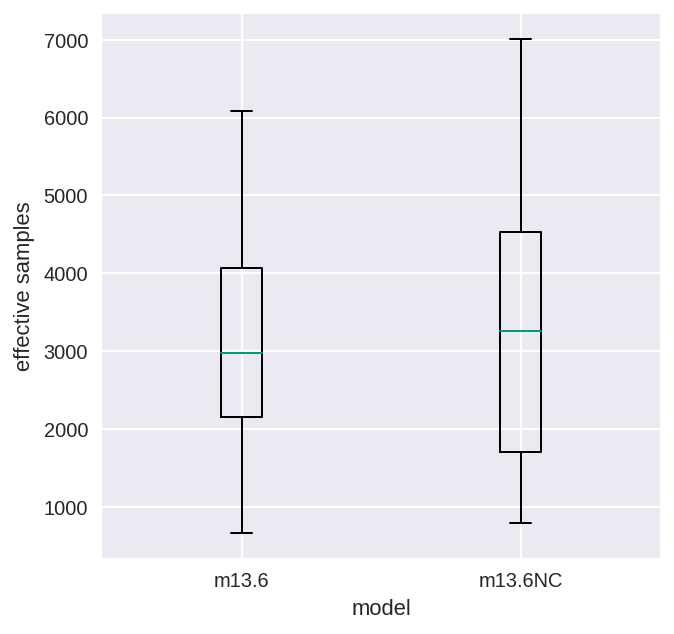

In [29]:
# extract n_eff values for each model
neff_c = pm.summary(trace_13_6)['n_eff'].values
neff_nc = pm.summary(trace_13_6NC)['n_eff'].values
# plot distributions
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.boxplot([neff_c, neff_nc], labels=['m13.6', 'm13.6NC']);
ax.set_xlabel('model')
ax.set_ylabel('effective samples');

#### Code 13.25

In [30]:
# I didnt compute the sigma from the chol above, got to get a bit more creative here
def unpack_sigma(pack_chol):
    idxs = np.tril_indices(3)
    chol_ = np.zeros((3, 3, pack_chol.shape[0]))
    chol_[idxs] = pack_chol.T
    chol = np.transpose(chol_, (2, 0, 1))
    cholt= np.transpose(chol, (0, 2, 1))
    sigma = np.matmul(chol, cholt)
    return np.sqrt(np.diagonal(sigma, axis1=1, axis2=2))

sigmadict = dict(Sigma_actor=unpack_sigma(trace_13_6NC.get_values('pchol_actor', combine=True)),
                 Sigma_block=unpack_sigma(trace_13_6NC.get_values('pchol_block', combine=True)))
trace_13_6NC.add_values(sigmadict)
pm.summary(trace_13_6NC, varnames=['Sigma_actor', 'Sigma_block']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Sigma_actor__0,2.36,0.91,0.02,1.00,4.12,1189.0,1.0
Sigma_actor__1,0.47,0.36,0.01,0.01,1.14,2888.0,1.0
Sigma_actor__2,0.53,0.48,0.01,0.01,1.42,1985.0,1.0
Sigma_block__0,0.24,0.22,0.01,0.00,0.65,793.0,1.0
Sigma_block__1,0.57,0.41,0.01,0.01,1.32,1844.0,1.0
Sigma_block__2,0.53,0.43,0.01,0.01,1.34,1205.0,1.0


#### Code 13.26
R and Rethinking related, skip for now

#### Code 13.27

In [31]:
with pm.Model() as m_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[actor] + a_block[block]
                         + (bp + bpC * d['condition']) * d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_12_5 = pm.sample(6000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 88%|████████▊ | 6174/7000 [00:59<00:07, 111.60it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 25 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 90%|█████████ | 6315/7000 [01:00<00:05, 130.11it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 35 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 96%|█████████▋| 6749/7000 [01:04<00:02, 124.76it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 6987/7000 [01:06<00:00, 129.34it/s]/home/

In [32]:
comp_df = pm.compare(traces=[trace_13_6NC, trace_12_5],
                     models=[model_13_6NC, m_12_5],
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m13.6NC', 'm12.5'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m12.5,532.78,10.5,0,0.69,19.66,0,0
m13.6NC,534.39,18.32,1.61,0.31,19.87,4.1,0


#### Code 13.28
Actually in model m_13_6NC I am already using the Cholesky decomposition of the covariance matrix. If we want to strictly follow the parameterization of m13.6NC and m13.6nc1 as in the book, we will model the Rho using pm.LKJCorr and do multiplication it with pm.HalfCauchy.

#### Code 13.29

In [3]:
Dmat = pd.read_csv('Data/islandsDistMatrix.csv', sep=",", index_col=0)
Dmat.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


#### Code 13.30

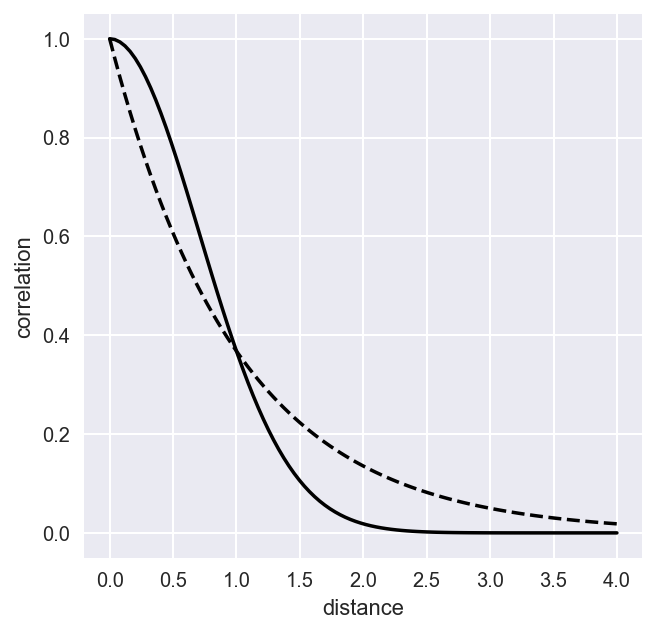

In [4]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
xrange = np.linspace(0, 4, 100)
ax.plot(xrange, np.exp(-1*xrange), 'k--')
ax.plot(xrange, np.exp(-1*xrange**2), 'k')
ax.set_xlabel('distance')
ax.set_ylabel('correlation');

#### Code 13.31

In [49]:
dk = pd.read_csv('Data/Kline2.csv', sep=",")
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)
Dmat_ = Dmat.values
Dmatsq = np.power(Dmat_, 2)

In [17]:
with pm.Model() as m_13_7:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7 = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [03:48<00:00, 10.89it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.55525311129, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 81 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


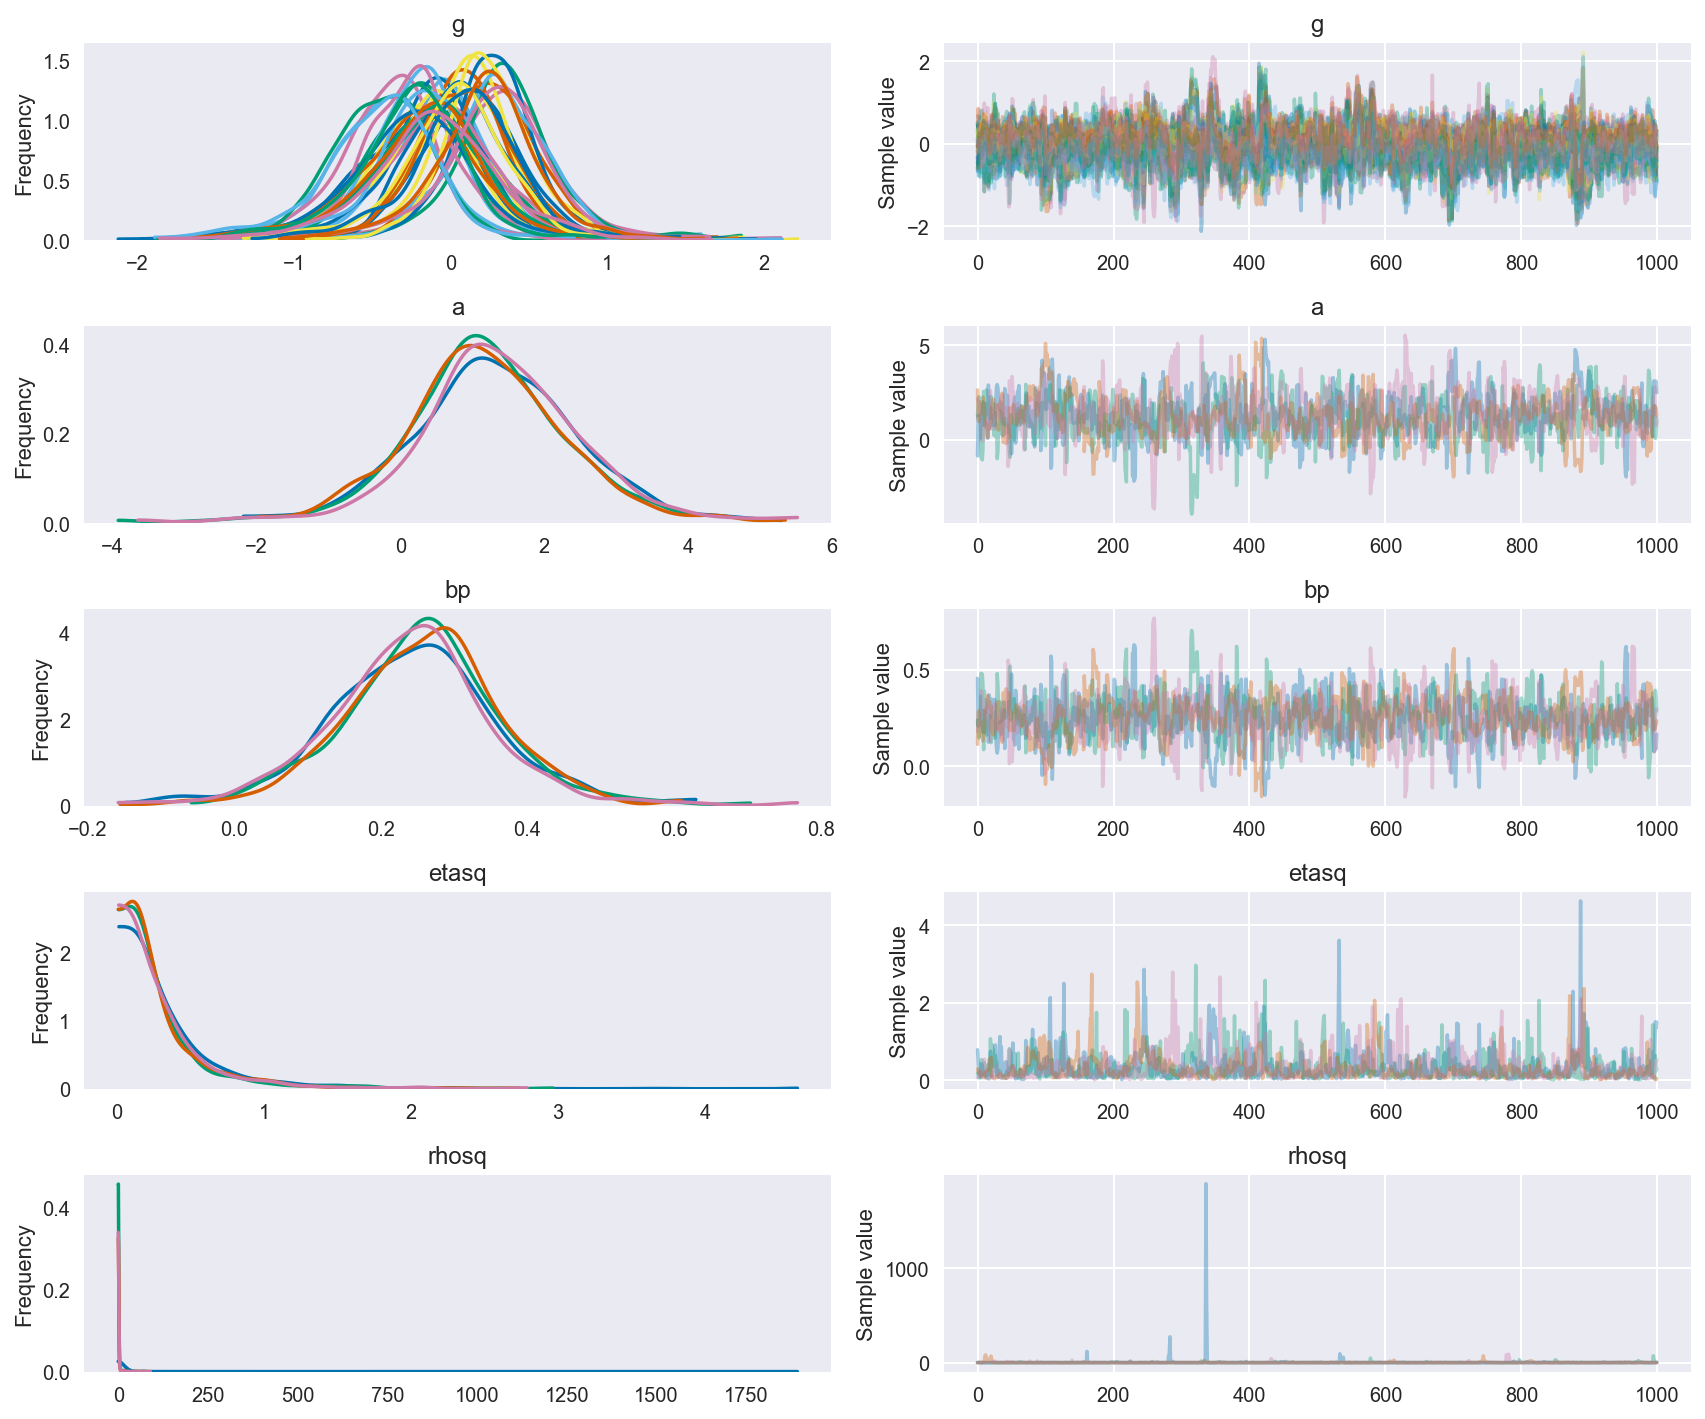

In [18]:
pm.traceplot(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']);

A reparameterization of m13.7

In [19]:
with pm.Model() as m_13_7_:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    # g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    gmu = pm.Normal('gmu', 0., 1., shape=Nsociety)
    g = pm.Deterministic('g', tt.dot(tt.slinalg.cholesky(Kij), gmu))
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7_ = pm.sample(1000, tune=1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 92%|█████████▏| 1839/2000 [02:35<00:13, 12.19it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 1999/2000 [02:46<00:00, 14.18it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [02:46<00:00, 12.01it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/n

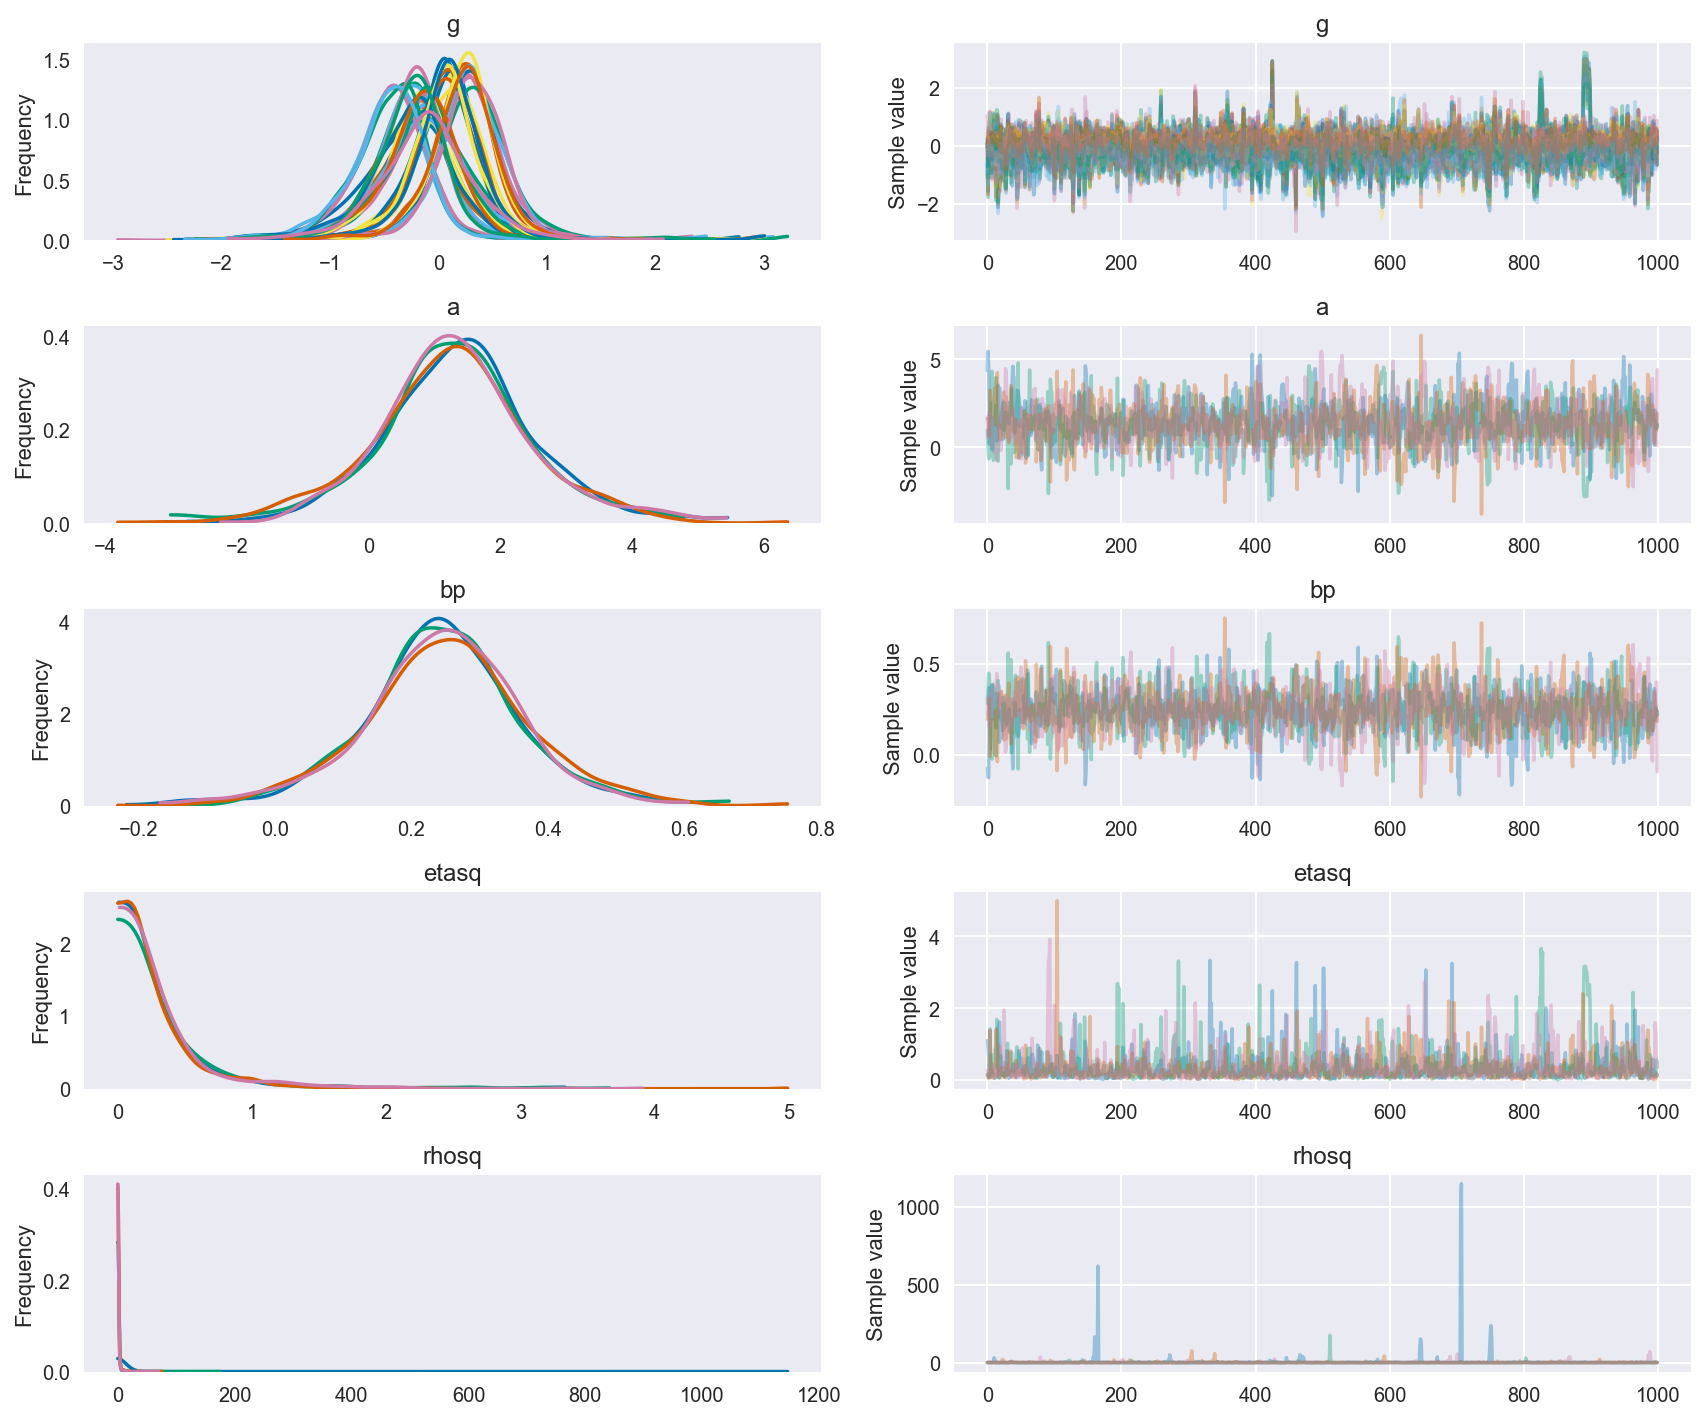

In [20]:
pm.traceplot(trace_13_7_, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']);

#### Code 13.32

In [21]:
pm.summary(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
g__0,-0.24,0.42,0.02,-1.26,0.52,473.0,1.0
g__1,-0.12,0.41,0.02,-1.02,0.69,449.0,1.0
g__2,-0.15,0.40,0.02,-1.14,0.55,444.0,1.0
g__3,0.31,0.36,0.02,-0.46,1.05,460.0,1.0
g__4,0.05,0.35,0.02,-0.72,0.75,465.0,1.0
g__5,-0.44,0.36,0.02,-1.20,0.24,488.0,1.0
g__6,0.11,0.35,0.02,-0.64,0.80,465.0,1.0
g__7,-0.25,0.35,0.02,-1.01,0.42,486.0,1.0
g__8,0.25,0.33,0.01,-0.42,0.90,446.0,1.0
g__9,-0.11,0.43,0.02,-0.94,0.82,776.0,1.0


In [22]:
pm.summary(trace_13_7_, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
g__0,-0.26,0.45,0.01,-1.18,0.62,1148.0,1.0
g__1,-0.13,0.45,0.01,-1.05,0.69,1102.0,1.0
g__2,-0.17,0.43,0.01,-1.08,0.64,1302.0,1.0
g__3,0.30,0.39,0.01,-0.48,1.02,1249.0,1.0
g__4,0.04,0.38,0.01,-0.69,0.78,1340.0,1.0
g__5,-0.45,0.39,0.01,-1.28,0.18,1300.0,1.0
g__6,0.10,0.38,0.01,-0.76,0.73,1355.0,1.0
g__7,-0.26,0.38,0.01,-1.10,0.36,1315.0,1.0
g__8,0.23,0.36,0.01,-0.49,0.87,1306.0,1.0
g__9,-0.12,0.46,0.01,-1.10,0.75,1536.0,1.0


#### Code 13.33

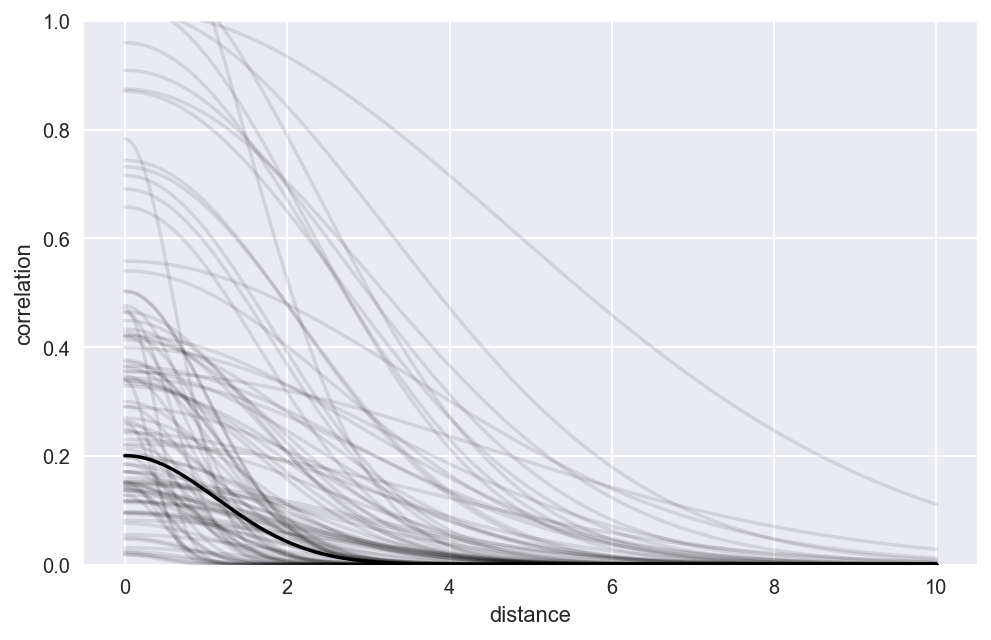

In [23]:
post = pm.trace_to_dataframe(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq'])
post_etasq = post['etasq'].values
post_rhosq = post['rhosq'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, 10, 200)

ax.plot(xrange, np.median(post_etasq)*np.exp(-np.median(post_rhosq)*xrange**2), 'k')
ax.plot(xrange, (post_etasq[:100][:, None]*np.exp(-post_rhosq[:100][:, None]*xrange**2)).T,
        'k', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance')
ax.set_ylabel('correlation');

#### Code 13.34

In [24]:
# compute posterior median covariance among societies
Kij_post = np.median(post_etasq)*(np.exp(-np.median(post_rhosq)*Dmatsq)+np.diag([.01]*Nsociety))

#### Code 13.35

In [25]:
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(Kij_post))
Rho = np.diag(sigma_post**-1).dot(Kij_post.dot(np.diag(sigma_post**-1)))
# add row/col names for convenience
Rho = pd.DataFrame(Rho, index=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"],
                  columns=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"])

Rho.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.91,0.85,0.00,0.55,0.20,0.02,0.05,0.26,0.0
Ti,0.91,1.00,0.95,0.00,0.55,0.21,0.04,0.06,0.22,0.0
SC,0.85,0.95,1.00,0.00,0.39,0.32,0.07,0.11,0.13,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.09,0.39,0.36,0.00,0.0
Fi,0.55,0.55,0.39,0.00,1.00,0.02,0.00,0.00,0.79,0.0
Tr,0.20,0.21,0.32,0.09,0.02,1.00,0.28,0.75,0.00,0.0
Ch,0.02,0.04,0.07,0.39,0.00,0.28,1.00,0.56,0.00,0.0
Mn,0.05,0.06,0.11,0.36,0.00,0.75,0.56,1.00,0.00,0.0
To,0.26,0.22,0.13,0.00,0.79,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


#### Code 13.36

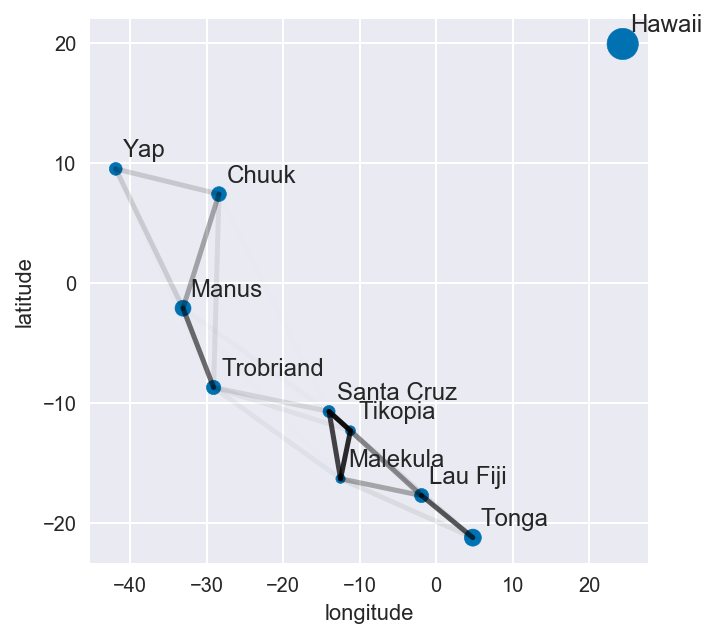

In [51]:
# scale point size to logpop
logpop = np.copy(dk['logpop'].values)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(dk['lon2'], dk['lat'], psize);
labels = dk['culture'].values
for i, itext in enumerate(labels):
    ax.text(dk['lon2'][i]+1, dk['lat'][i]+1, itext)
# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i+1, 10):
        ax.plot([dk['lon2'][i], dk['lon2'][j]],
                [dk['lat'][i], dk['lat'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

#### Code 13.37

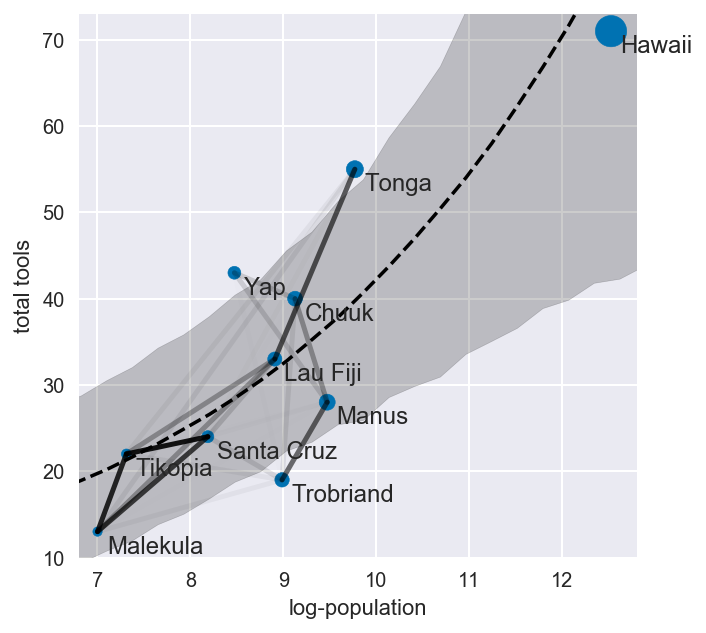

In [58]:
Nsamp, Nbin = 1000, 30
log_pop_seq = np.linspace(6, 14, Nbin)
a_post = trace_13_7.get_values(varname='a', combine=True)[:, None]
bp_post = trace_13_7.get_values(varname='bp', combine=True)[:, None]
lambda_post = np.exp(a_post + bp_post*log_pop_seq)

# plot raw data
_, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(log_pop_seq, np.median(lambda_post, axis=0), '--', color='k')

alpha = .2
mu_hpd = pm.hpd(lambda_post, alpha=alpha)
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=alpha*.5+.1, color='k')

axes.scatter(dk['logpop'], dk['total_tools'], psize)
labels = dk['culture'].values
for i, itext in enumerate(labels):
    axes.text(dk['logpop'][i]+.1, dk['total_tools'][i]-2.5, itext)
    
# overlay correlations
for i in range(10):
    for j in np.arange(i+1, 10):
        axes.plot([dk['logpop'][i], dk['logpop'][j]],
                [dk['total_tools'][i], dk['total_tools'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
        
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 13.38
Practice session, skip for now.

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))